*This notebook is a work in progress. Please send notes, comments and other suggestions to [olafur.bogason@mail.mcgill.ca](olafur.bogason@mail.mcgill.ca)*

When starting out Wave Digital Filters (WDFs) can seem cryptic and implementing them time consuming to say the least. In this notebook I hope to shed some light on WDFs and how they work out in practice. This is not a review article on current research trends. This is an article I wish I had read when I started to dabble with the theory.

# Wave Digital Filters

Wave Digital Filters were first mentioned in a German patent filed in the late 1960s by Alfred Fettweis. Originally they were used to discretize RCL ladder circuits, that is circuits that can be decomposed into a cascade of series and parallel connections. WDFs can be seen as a [finite difference scheme](https://en.wikipedia.org/wiki/Finite_difference_method) with some nice numerical properties. WDFs allow an audio DSP designer to create algorithms that are *physically informed*. That is, algorithms that retain underlying structure (topology) of a reference circuit and use physical approximations, traditionally [a lumped model](https://en.wikipedia.org/wiki/Lumped_element_model), of how circuit components behave. 

The Wave part of Wave Digital Filters is a reference to the fact that the independent variables in the WD-domain are so called wave-variables (which all EE engineers know from [Two-port networks](https://en.wikipedia.org/wiki/two-port_network)). Having waves as independent variables allows the use of concepts such as [scattering](https://en.wikipedia.org/wiki/Scattering) and [impedence matching](https://en.wikipedia.org/wiki/Impedance_matching).

For each lumped element in the Kirchoff/K-domain there exists a *port* in the Wave Digital/WD-domain. Similarly for series and parallel connections in the K-domain there exist series and parallel *adaptors* in the WD-domain. Many circuits in the wild however cannot be split into a cascade of series and parallel adaptors.

That means that the scope of circuits that were tractable via WDF was very limited. Recently researchers have found a way to use WDFs to cover [arbitrary topologies](http://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_53.pdf). This method proposed to use of [Modified Nodal Analysis](https://en.wikipedia.org/wiki/Modified_nodal_analysis) along with some clever linear algebra tricks to describe the scattering behaviour of a multi-port R-type (Rigid) adaptor.

---

Examples on how to implement WD-structures will be given in Python code. The reason for choosing Python is that it is an interpreted language and its simplicity allows me to concentrate on the explanation of WD concepts rather than the programming itself. There is a nice real-time C++ library being developed [here](https://github.com/RT-WDF/rt-wdf_lib).

To keep things simple, classes are used to handle individual WD ports. Simple functions are used for adaptors to show how the computation is done. Instead of displaying all the code at once, snippets are interleaved with the text. Results from simulations of WD structures are compared to results obtained by simulating the same circuits in [LTspice](http://www.linear.com/designtools/software/).

In [117]:
%matplotlib inline

# Some auxillary code.
import numpy as np
import pandas as pd
from scipy import signal
from sympy import *
import matplotlib.pyplot as plt

FS = 96e3  # Sample frequency.  
N = 2**14  # Number of points to simulate.

input = np.zeros(N)
input[0] = 1  # Input is a delta function.
output = np.zeros(input.size)
steps  = np.arange(N)

# Make legends nicer and find best location for box.
legend_style = {"loc":0, "frameon":False, "fontsize":10}

def plot_freqz(x, title="Frequency response"):
    # Plot the frequency response of a signal x.
    ax = plt.subplot(111)
    w, h = signal.freqz(x, 1, 2048*2)
    H = 20 * np.log10(np.abs(h))
    f = w / (2 * np.pi) * FS
    # Make plot pretty.
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.semilogx(f, H, label="WDF")
    plt.xlim([np.min(f), np.max(f)])
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')

def plot_ltspice_freqz(filename, title="Frequency response", out_label='V(vout)'):
    # Plot the frequency responce of a LTspice simulation containing
    # frequency and complex signal.
    def imag_to_mag(z):
        # Returns the maginude of an imaginary number.
        a, b = map(float, z.split(','))
        return 20*np.log10(np.sqrt(a*a + b*b))
    
    x = pd.read_csv(filename, delim_whitespace=True)
    x['H_dB'] = x[out_label].apply(imag_to_mag)

    f = np.array(x['Freq.'])
    H_db = np.array(x['H_dB'])
    plt.semilogx(f, H_db, label="LTspice")

# WD-domain variables
One-port elements in electrical circuits include components such as resistors, capacitors and inductors. They also include ideal and resistive voltage and current sources along with short and open circuits. Many more one-port elements exist, but those are some of the elements that have already been ported over to the WD-domain and are used in practice. 

K-domain variables $v$ and $i$ are linearly mapped to WD-domain variables $a$ and $b$ with the following linear transforms:

\begin{align}
a &= v + i \cdot R_p \\ 
b &= v - i \cdot R_p 
\end{align}

\begin{align}
v &= \frac{1}{2}(a + b) \\ 
i &= \frac{1}{2 R_p}(a - b)
\end{align}

$R_p$ is called a **port resistance**. It is physically introduced into the system, meaning that in practice it can be set to any real value.

![](files/images/port.png)
The picture above catches the most important variables in one place. We have the instantaneous Thévenin port equivalence circuit ($v_s$, $R_s$) along with independent variables in K-domain, $V$, $i$ and in the WD-domain $a$, $b$ and the port resistance $R_p$.

# Discretization of dynamic elements

An integral part of coming up with a WDF structure is to digitize the reactive components in the reference circuit. Although most text out there will only mention the use of biliear transform to digitze circuits, it is by no means the only way. There are even certain cases where using it may render the [WD simulation unstable](https://www.ntnu.edu/documents/1001201110/1266017954/DAFx-15_submission_52.pdf). For our case we will still use it for the sake of its simplicity.

\begin{align}
s & \leftarrow \frac{1}{2 f_s} \frac{z - 1}{z + 1}
\end{align}

There is one thing to keep in mind during the following derivations. For the resulting WDF structure to be computable we cannot have any delay-free loops inside it. That means that for each one-port element we are looking for a function $f$ that maps $a$ -> $b$ but $b_t$ cannot depend on $a_t$. It can only on delayed versions of $a$, e.g. $a_{t-1}$.

To deal with this issue we have two theoretical tools at our disposal: (a) the port resistance, (b) adapt a port of an adaptor by using the concept of scattering. Adapting a port or making it reflection free means that we choose the port resistance at that port so that the reflected wave does not depend directly on the incident wave at that same port. Note that the reflected wave can, and often will, depend on incident waves from other ports of the same adaptor.

# One port elements
Starting with the K-domain representaion of a one-port element it is is simple to derive the most common one-port elements. The linear mappings between the K- and WD-domain are used extensively in this part.

In [135]:
class baseWDF(object):
    def __init__(self):
        # Incident- and reflected wave variables.
        self.a, self.b = 0, 0
        self.parent = None

    def connect_to_parent(self,p):
        self.parent = p

    def connect_to_node(self,p):
        self.parent = p

    def calcImpedance(self):
        pass
        
    def propogateImpedanceChange(self):
        self.calcImpedance()
        if self.parent != None:
            self.parent.propogateImpedanceChange()
    
    def wave_to_voltage(self):
        voltage = (self.a + self.b) / 2
        return voltage


class RootWDF(baseWDF):
    def __init__(self):
        baseWDF.__init__(self)

    def connectToParent(self,p):
        pass

    def connect_to_node(self,next):
        self.next = 0
        next.connect_to_node(self)

    def propogateImpedanceChange(self):
        self.calcImpedance()

In [134]:
class Resistor(baseWDF):

    def __init__(self,R=1e-9):
        baseWDF.__init__(self)
        self.calcImpedance(R)

    def setResistance(self,newR):
        if self.Rp == newR:
            return
        self.Rp = newR
        self.G = 1. / newR
        self.propogateImpedanceChange()

    def calcImpedance(self,R):
        self.Rp = R
        self.G = 1. / R

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        self.b = 0
        return self.b


In [133]:
class Capacitor(baseWDF):
    def __init__(self,cap,fs):
        baseWDF.__init__(self)
        self.z = 0
        self.calcImpedance(cap,fs)

    def prepare(self,new_fs):
        self.fs = new_fs
        self.propogateImpedanceChange()
        self.reset()

    def set_capacitance(self,cap):
        if self.C == cap:
            return
        self.C = cap
        self.propogateImpedanceChange()

    def calcImpedance(self,C,fs):
        self.C = C
        self.fs = fs
        self.Rp = 1 / self.C * 2 * self.fs
        self.G = 1 / self.Rp
        
    def accept_incident_wave(self,a):
        self.a = a
        self.z = self.a

    def propogate_reflected_wave(self):
        self.b = self.z
        return self.b

    def reset(self):
        self.z = 0

In [132]:
class Inductor(baseWDF):
    def __init__(self,L,fs):
        baseWDF.__init__(self)
        self.z = 0
        self.calcImpedance(L,fs)

    def prepare(self,new_fs):
        self.fs = new_fs
        self.propogateImpedanceChange()
        self.reset()

    def reset(self):
        self.z = 0

    def set_inductance(self,L):
        if self.L == L:
            return
        self.L = L
        self.propogateImpedanceChange()

    def calcImpedance(self,L,fs):
        self.L = L
        self.Rp = 2 * L * fs
        self.G = 1. / self.Rp

    def accept_incident_wave(self,a):
        self.a = a
        self.z = self.a

    def propogate_reflected_wave(self):
        self.b = -self.z
        return self.b

    

In [136]:
# 3 port parallel adaptor

class parallel_adaptor(baseWDF):
    def __init__(self,p1,p2):
        baseWDF.__init__(self)
        self.p1 = p1
        self.p2 = p2
        self.bTemp = 0
        self.bDiff = 0
        self.port1Reflect = 1
        p1.connect_to_parent(self)
        p2.connect_to_parent(self)
        self.calcImpedance()

    def calcImpedance(self):
        self.G = self.p1.G + self.p2.G
        self.Rp = 1. / self.G
        self.port1Reflect = self.p1.G / self.G

    def accept_incident_wave(self,a):
        b2 = a + self.bTemp
        self.p1.accept_incident_wave(self.bDiff + b2)
        self.p2.accept_incident_wave(b2)
        self.a = a

    def propogate_reflected_wave(self):
        self.p1.propogate_reflected_wave()
        self.p2.propogate_reflected_wave()
        self.bDiff = self.p2.b - self.p1.b
        self.bTemp = 0 - self.port1Reflect * self.bDiff
        self.b = self.p2.b + self.bTemp
        return self.b
        

In [137]:
# 3 port series adaptor

class series_adaptor(baseWDF):
    def __init__(self,p1,p2):
        baseWDF.__init__(self)
        self.p1 = p1
        self.p2 = p2
        self.port1Reflect = 1
        self.calcImpedance()
        p1.connect_to_parent(self)
        p2.connect_to_parent(self)

    def calcImpedance(self):
        self.Rp = self.p1.Rp + self.p2.Rp
        self.G = 1. / self.Rp
        self.port1Reflect = self.p1.Rp / self.Rp

    def accept_incident_wave(self,a):
        b1 = self.p1.b - self.port1Reflect * (a + self.p1.b + self.p2.b)
        self.p1.accept_incident_wave(b1)
        self.p2.accept_incident_wave(0 - (a + b1)) 
        self.a = a
        
    def propogate_reflected_wave(self):
        self.b = 0 - (self.p1.propogate_reflected_wave() + self.p2.propogate_reflected_wave())
        return self.b

In [124]:
# polarity inverter

class polarity_inverter(baseWDF):
    def __init__(self,p1):
        baseWDF.__init__(self)
        p1.connect_to_parent(self)
        self.p1 = p1
        self.calcImpedance()

    def calcImpedance(self):
        self.Rp = self.p1.Rp
        self.G = 1. / self.Rp

    def accept_incident_wave(self,a):
        self.a = a
        self.p1.accept_incident_wave(0 - a)

    def propogate_reflected_wave(self):
        self.b = 0 - self.p1.propogate_reflected_wave()
        return self.b


In [139]:
# voltage sources

class ideal_voltage_source(RootWDF):
    def __init__(self,next):
        RootWDF.__init__(self)
        next.connect_to_parent(self)
        self.next = next
        self.Vs = 0
        self.calcImpedance()

    def calcImpedance(self):
        pass

    def set_voltage(self,newV):
        self.Vs = newV

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        self.b = 0 - self.a * 2 * self.Vs
        return self.b

class resistive_voltage_source(baseWDF):
    def __init__(self):
        baseWDF.__init__(self)
        self.Rval = 1e-9
        self.Vs = 0
        self.calcImpedance()

    def set_resistance_value(self,newR):
        if self.Rval == newR:
            return
        self.Rval = newR
        self.propogateImpedanceChange()

    def calcImpedance(self):
        self.Rp = self.Rval
        self.G = 1. / self.Rp

    def set_voltage(self,newV):
        self.Vs = newV

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        self.b = self.Vs
        return self.b

In [126]:
# current sources

class ideal_current_source(RootWDF):
    def __init__(self,next):
        RootWDF.__init__(self)
        self.next = next
        self.Is = 0
        next.connect_to_parent(self)
        self.calcImpedance()

    def calcImpedance(self):
        self.twoR = 2 * next.Rp
        self.twoR_Is = self.twoR * self.Is

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        self.b = self.twoR_Is + self.a
        return self.b

class resistive_current_source(baseWDF):
    def __init__(self):
        baseWDF.__init__(self)
        self.Is = 0
        self.Rval = 1e9
        self.calcImpedance()

    def set_resistance_value(self,newR):
        if self.Rval == newR:
            return
        self.Rval = newR
        self.propogateImpedanceChange()

    def calcImpedance(self):
        self.Rp = self.Rval
        self.G = 1. / self.Rp

    def set_current(self,newI):
        self.Is = newI
    
    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        self.b = self.Rp * self.Is
        return self.b    

In [140]:
def omega3(x):
    """
    3rd order approximation of wright omega function
    """
    x1 =  -3.341459552768620
    x2 = 8.0
    a =  -1.314293149877800e-3
    b = 4.775931364975583e-2
    c = 3.631952663804445e-1
    d = 6.313183464296682e-1
    if x < x1:
        return 0
    elif x < x2:
        return d + x * (c + x * (b + x * a))
    return x - np.log(x)

def omega4(x):
    """
    4th order approximation of wright omega function
    """
    y = omega3(x)
    return y - (y - np.exp(x - y)) / (y + 1)


In [141]:
# diodes

class Diode(RootWDF):
    def __init__(self,next,Is,Vt=25.85e-3,nDiodes=1):
        RootWDF.__init__(self)
        self.next = next
        next.connect_to_parent(self)
        self.set_diode_params(Is,Vt,nDiodes)

    def set_diode_params(self,Is,Vt,nDiodes):
        self.Is = Is
        self.Vt = Vt * nDiodes
        self.oneOverVt = 1. / self.Vt
        self.calcImpedance()

    def calcImpedance(self):
        self.twoR_Is = 2 * self.next.Rp * self.Is
        self.R_Is_Over_Vt = self.next.Rp * self.Is * self.oneOverVt
        self.logR_Is_Over_Vt = np.log(self.R_Is_Over_Vt)

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_incident_wave(self):
        self.b = self.a + self.twoR_Is - 2 * self.Vt * omega4(self.logR_Is_Over_Vt + self.a * self.oneOverVt + self.R_Is_Over_Vt)
        return self.b

class diodePair(RootWDF):
    def __init__(self,next,Is,Vt=25.85e-3,nDiodes=2):
        RootWDF.__init__(self)
        self.next = next
        next.connect_to_parent(self)
        self.set_diode_params(Is,Vt,nDiodes)

    def set_diode_params(self,Is,Vt,nDiodes):
        self.Is = Is
        self.Vt = nDiodes * Vt
        self.oneOverVt = 1./ self.Vt
        self.calcImpedance()

    def calcImpedance(self):
        self.R_Is = self.next.Rp * self.Is
        self.R_Is_Over_Vt = self.R_Is / self.Vt
        self.logR_Is_Over_Vt = np.log(self.R_Is_Over_Vt)

    def accept_incident_wave(self,a):
        self.a = a

    def propogate_reflected_wave(self):
        try:
            lam = np.sign(self.a)
        except:
            lam = 0
        lam_a_over_Vt = lam * self.a * self.oneOverVt
        self.b = self.a - 2 * self.Vt * lam * omega4(self.logR_Is_Over_Vt + lam_a_over_Vt) - omega4(self.logR_Is_Over_Vt - lam_a_over_Vt)
        return self.b


# Circuit simulation with wdfs

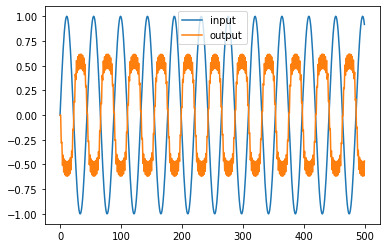

In [174]:
# simulation
import scipy.io.wavfile

# fs,audio = scipy.io.wavfile.read('./audio/arp-lead-clean.wav')
fs = 44100

N = 1.5 * fs
f = 1000
amp = 1
n = np.arange(0,2*N/fs,1/fs)
x = np.sin(2 * np.pi * f * n) * amp
output = np.zeros(x.shape)
# output = np.zeros(audio.shape)

R1 = Resistor(4700)
Vs = resistive_voltage_source()
S1 = series_adaptor(Vs,R1)
C1 = Capacitor(47e-9,fs)
P1 = parallel_adaptor(S1,C1)
dp = diodePair(P1,2.52e-9)

for i in range(len(x)):
    Vs.set_voltage(x[i])
    dp.accept_incident_wave(P1.propogate_reflected_wave())
    y = C1.wave_to_voltage()
    P1.accept_incident_wave(dp.propogate_reflected_wave())
    output[i] = y

plt.plot(x[:500],label='input')
plt.plot(output[:500],label='output')
plt.legend()

scipy.io.wavfile.write('./audio/sineIn.wav',fs,x)
scipy.io.wavfile.write('./audio/sineOut.wav',fs,output)
!open './audio/sineIn.wav'
!open './audio/sineOut.wav'


### WDF Resistor
\begin{align}
Z_R = R &= \frac{v}{i} \\
    &= \frac{\frac{1}{2}(a + b)}{\frac{1}{2 R_p}(a - b)}
\end{align}

$$ b = \frac{R - R_p}{R + R_p} a $$

If we write that out with explicit time we get:

$$ b[n] = \frac{R - R_p}{R + R_p} a[n] $$

so we see that the reflected wave depends instantaneously on the incident wave: We have a delay-free loop. To break that loop we must use our free parameter and set $R_p = R$. That choice causes $Z_R = 0$ and $b = 0$ for all resistor elements. In other words it means that the reflected wave is always zero independent on the value of inciding wave! But what does that really mean? Will resistors not contribute at all to the WDF structure? 

Far from it. Because we set the port resistance equal to the physical resistance of resitors they directly contribute to the scattering of incident waves at the adaptor connected to any given resistor. More about that later. 

![](files/images/resistor.png)